# **Setup, Imports & Data Loading**

🔹 Description:

* Import required libraries

* Mount Google Drive

* Extract dataset from ZIP

* Display folder structure for verification

In [ ]:
# STEP 1: SETUP, IMPORTS, AND LOAD DATASET

from google.colab import drive
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to your ZIP file in Google Drive
zip_path = "/content/drive/MyDrive/Brain_Tumor_Dataset.zip"
extract_path = "/content/Brain_Tumor_Dataset"

# Unzip if not already unzipped
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Check directory structure briefly
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files[:3]:
        print(f'{subindent}{f}')


Mounted at /content/drive
Brain_Tumor_Dataset/
    Testing/
        pituitary/
            Te-pi_0090.jpg
            Te-pi_0288.jpg
            Te-pi_0142.jpg
        glioma/
            Te-gl_0064.jpg
            Te-glTr_0006.jpg
            Te-gl_0208.jpg
        notumor/
            Te-no_0179.jpg
            Te-no_0026.jpg
            Te-no_0228.jpg
        meningioma/
            Te-me_0132.jpg
            Te-me_0080.jpg
            Te-me_0263.jpg
    Training/
        pituitary/
            Tr-pi_0432.jpg
            Tr-pi_0287.jpg
            Tr-pi_0232.jpg
        glioma/
            Tr-gl_0354.jpg
            Tr-gl_0131.jpg
            Tr-gl_0505.jpg
        notumor/
            Tr-no_1148.jpg
            Tr-no_0031.jpg
            Tr-no_0259.jpg
        meningioma/
            Tr-me_1121.jpg
            Tr-me_0565.jpg
            Tr-me_0979.jpg


# **Visualize Image Count per Class**

🔹 Description:

* Count number of images for each tumor class in both training and testing sets

* Plot a bar chart to check dataset balance and class distribution

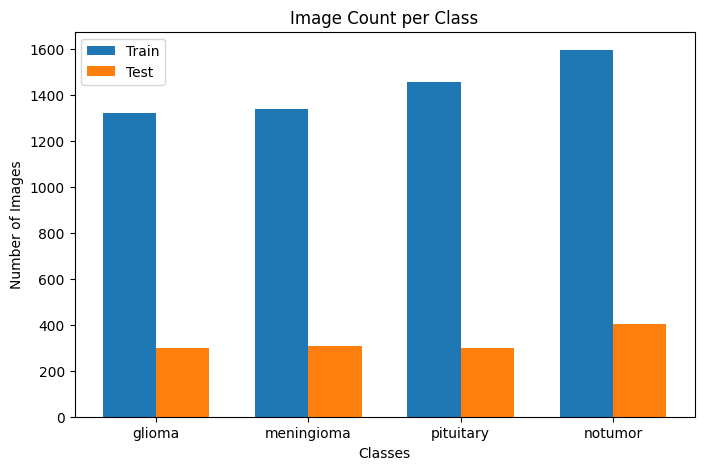

In [ ]:
# STEP 2: COUNT IMAGES PER CLASS AND PLOT BAR CHART

classes = ['glioma', 'meningioma', 'pituitary', 'notumor']
data_dirs = {
    'Training': os.path.join(extract_path, 'Training'),
    'Testing': os.path.join(extract_path, 'Testing')
}

def count_images(directory):
    counts = {}
    for cls in classes:
        path = os.path.join(directory, cls)
        counts[cls] = len(os.listdir(path))
    return counts

train_counts = count_images(data_dirs['Training'])
test_counts = count_images(data_dirs['Testing'])

def plot_class_distribution(train_counts, test_counts):
    x = np.arange(len(classes))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, [train_counts[cls] for cls in classes], width, label='Train')
    ax.bar(x + width/2, [test_counts[cls] for cls in classes], width, label='Test')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Images')
    ax.set_title('Image Count per Class')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()
    plt.show()

plot_class_distribution(train_counts, test_counts)

# Display Sample Images per Class

🔹 Description:

* Randomly select and display one image from each tumor class

* Helps visually verify the dataset and understand class differences

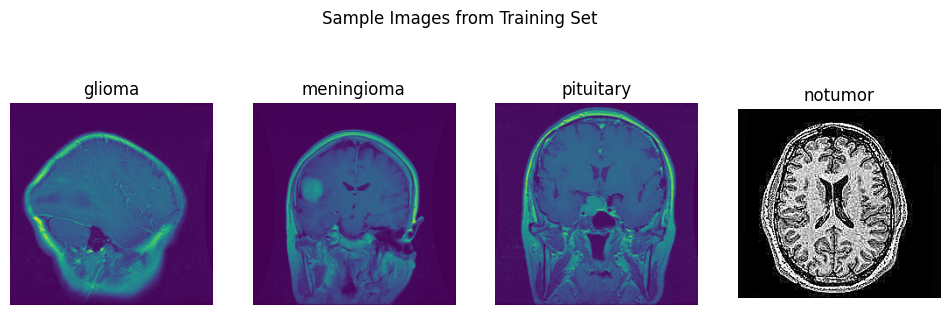

In [ ]:
# STEP 3: SHOW SAMPLE IMAGES FROM EACH CLASS

def show_sample_images(dataset_path):
    plt.figure(figsize=(12, 4))
    for i, cls in enumerate(classes):
        folder = os.path.join(dataset_path, cls)
        img_path = random.choice(os.listdir(folder))
        img = Image.open(os.path.join(folder, img_path))
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
    plt.suptitle('Sample Images from Training Set')
    plt.show()

show_sample_images(data_dirs['Training'])

# Create Data Generators & Show Class Indices

🔹 Description:

* Apply VGG16-style preprocessing & data augmentation using ImageDataGenerator

* Load training and testing data from folders

* Print class label-to-index mapping used by the model





In [ ]:
# STEP 4: PRINT CLASS INDICES

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Initial preprocessing function: VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

train_datagen = ImageDataGenerator(
    preprocessing_function=vgg_preprocess,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess)

train_generator = train_datagen.flow_from_directory(
    data_dirs['Training'],
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    data_dirs['Testing'],
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices
print("Class indices:", class_indices)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Build, Train & Evaluate Models

🔹 Description:

* Define a transfer learning model using a frozen base CNN

* Add classification layers (GAP, Dense, Dropout, Softmax)

* Include functions to plot training history and evaluate performance using classification report, confusion matrix, and metrics like Accuracy, F1, AUC

* Utility to reset data generators for different model preprocessing

In [ ]:
# STEP 5: MODEL BUILDING, TRAINING, EVALUATION FUNCTIONS

def build_model(base_model, num_classes=4):
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    return model

def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(20, 5))
    for i, (name, history) in enumerate(histories.items()):
        plt.subplot(1, len(histories), i + 1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.title(f'{name} {metric.title()}')
        plt.legend()
    plt.show()

def evaluate_model(model, generator, class_names):
    y_true = generator.classes
    y_pred_probs = model.predict(generator)
    y_pred = y_pred_probs.argmax(axis=1)

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # For multiclass AUC, use "ovo" or "ovr" strategy
    try:
        y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
        auc = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovo')
    except Exception as e:
        print("AUC calculation error:", e)
        auc = None

    return acc, f1, precision, recall, auc

# Helper to reset generators' preprocessing functions (important for each model)
def reset_generators(preprocess_func):
    global train_generator, test_generator
    train_generator.preprocessing_function = preprocess_func
    test_generator.preprocessing_function = preprocess_func

# Train VGG16 Model & Evaluate
🔹 Description:

* Use VGG16 (pretrained on ImageNet) as the base model for transfer learning

* Freeze base layers, add custom classification layers

* Train the model and validate on test data

* Evaluate using accuracy, F1, precision, recall, and AUC

🧠 About VGG16:
VGG16 is a deep CNN known for its simple and uniform architecture (stacked 3×3 conv layers). It extracts high-level features useful for medical image classification.

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 117s 581ms/step - accuracy: 0.4144 - loss: 2.5168 - val_accuracy: 0.7223 - val_loss: 0.7966
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 112s 479ms/step - accuracy: 0.6575 - loss: 1.0198 - val_accuracy: 0.8009 - val_loss: 0.5703
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 480ms/step - accuracy: 0.7426 - loss: 0.6993 - val_accuracy: 0.8078 - val_loss: 0.5177
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 477ms/step - accuracy: 0.7881 - loss: 0.5834 - val_accuracy: 0.8261 - val_loss: 0.4680
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 500ms/step - accuracy: 0.7930 - loss: 0.5621 - val_accuracy: 0.8337 - val_loss: 0.4481
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 480ms/step - accuracy: 0.8067 - loss: 0.5184 - val_accuracy: 0.8314 - val_loss: 0.4319
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 484ms/step - accuracy: 0.8261 - loss: 0.4672 - val_accuracy: 0.8459 - val_loss: 0.3995
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 482ms/step - accuracy: 0.8303 - loss:

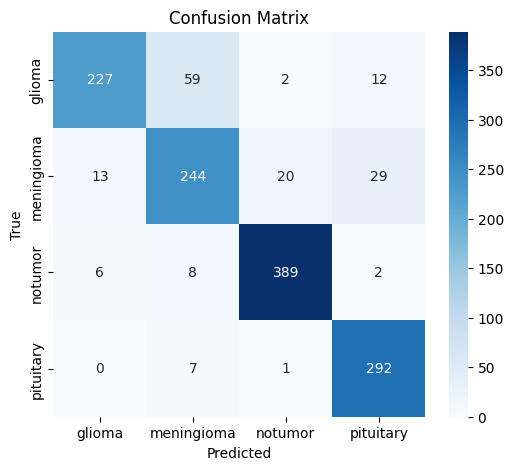

In [ ]:
# STEP 6: TRAIN ALL MODELS AND COLLECT RESULTS

histories = {}
results = []

# VGG16
from tensorflow.keras.applications import VGG16
reset_generators(vgg_preprocess)
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = build_model(base_vgg)
histories['VGG16'] = vgg_model.fit(train_generator, validation_data=test_generator, epochs=15, verbose=1)
print("Evaluating VGG16...")
vgg_metrics = evaluate_model(vgg_model, test_generator, list(class_indices.keys()))
results.append(('VGG16',) + vgg_metrics)

# Train ResNet50 Model & Evaluate

🔹 Description:

* Load ResNet50 pretrained on ImageNet as the base

* Reset generators with ResNet-specific preprocessing

* Train the model and record performance

* Evaluate with metrics and confusion matrix

🧠 About ResNet50:
ResNet50 introduces residual connections (skip connections) that help train deeper networks by avoiding vanishing gradients. It’s highly effective for complex image classification tasks like medical diagnostics.



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 106s 516ms/step - accuracy: 0.5555 - loss: 1.1112 - val_accuracy: 0.8063 - val_loss: 0.4941
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 443ms/step - accuracy: 0.8251 - loss: 0.4975 - val_accuracy: 0.8368 - val_loss: 0.4137
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 442ms/step - accuracy: 0.8413 - loss: 0.4230 - val_accuracy: 0.8566 - val_loss: 0.3827
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 451ms/step - accuracy: 0.8618 - loss: 0.3633 - val_accuracy: 0.8696 - val_loss: 0.3455
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 446ms/step - accuracy: 0.8680 - loss: 0.3393 - val_accuracy: 0.8719 - val_loss: 0.3275
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 446ms/step - accuracy: 0.8880 - loss: 0.3116 - val_accuracy: 0.8772 - val_loss: 0.3255
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 445ms/step - accuracy: 0.8972 - loss: 0.2897 - val_accuracy: 0.8902 - val_loss: 0.2959
Epoch 8/15
179/179 ━━━━━━━━━━━━

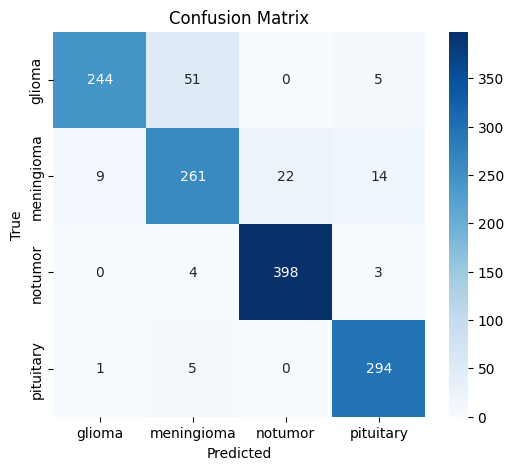

In [ ]:
# ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
reset_generators(resnet_preprocess)
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = build_model(base_resnet)
histories['ResNet50'] = resnet_model.fit(train_generator, validation_data=test_generator, epochs=15, verbose=1)
print("Evaluating ResNet50...")
resnet_metrics = evaluate_model(resnet_model, test_generator, list(class_indices.keys()))
results.append(('ResNet50',) + resnet_metrics)

# Train InceptionV3 Model & Evaluate

🔹 Description:

* Load InceptionV3 pretrained model

* Apply Inception-specific preprocessing

* Train on tumor dataset, validate on test set

* Collect evaluation metrics

🧠 About InceptionV3:
InceptionV3 is a deep CNN that uses multi-scale convolutions (1x1, 3x3, 5x5) within the same layer (Inception modules). It’s optimized for both speed and accuracy, making it suitable for high-resolution medical imaging tasks.

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 121s 588ms/step - accuracy: 0.3804 - loss: 21.6753 - val_accuracy: 0.5111 - val_loss: 1.8510
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 442ms/step - accuracy: 0.4749 - loss: 1.8337 - val_accuracy: 0.4928 - val_loss: 1.2126
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 433ms/step - accuracy: 0.4775 - loss: 1.2391 - val_accuracy: 0.4928 - val_loss: 1.1658
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 436ms/step - accuracy: 0.4845 - loss: 1.1888 - val_accuracy: 0.5149 - val_loss: 1.1523
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 438ms/step - accuracy: 0.5157 - loss: 1.1274 - val_accuracy: 0.5103 - val_loss: 1.1416
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 441ms/step - accuracy: 0.5368 - loss: 1.0890 - val_accuracy: 0.5027 - val_loss: 1.1199
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 440ms/step - accuracy: 0.5278 - loss: 1.0809 - val_accuracy: 0.5309 - val_loss: 1.1034
Epoch 8/15
179/179 ━━━━━━━━━━━

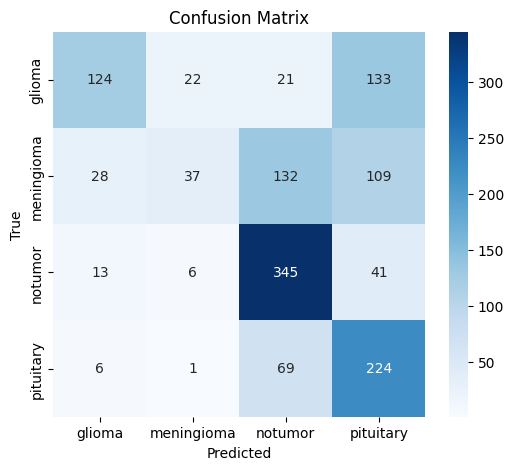

In [ ]:
# InceptionV3
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
reset_generators(inception_preprocess)
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_model = build_model(base_inception)
histories['InceptionV3'] = inception_model.fit(train_generator, validation_data=test_generator, epochs=15, verbose=1)
print("Evaluating InceptionV3...")
inception_metrics = evaluate_model(inception_model, test_generator, list(class_indices.keys()))
results.append(('InceptionV3',) + inception_metrics)

# Train MobileNetV2 Model & Evaluate

🔹 Description:

* Load MobileNetV2 with pretrained ImageNet weights

* Use its lightweight architecture for efficient training

* Train and evaluate on brain tumor dataset

* Record key performance metrics

🧠 About MobileNetV2:
MobileNetV2 is a lightweight, efficient CNN designed for mobile and embedded devices. It uses depthwise separable convolutions and inverted residuals to reduce computational cost while maintaining accuracy.

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 471ms/step - accuracy: 0.4481 - loss: 1.3506 - val_accuracy: 0.7468 - val_loss: 0.7056
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 418ms/step - accuracy: 0.7409 - loss: 0.6816 - val_accuracy: 0.7696 - val_loss: 0.6143
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 422ms/step - accuracy: 0.7735 - loss: 0.5972 - val_accuracy: 0.7941 - val_loss: 0.5738
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 407ms/step - accuracy: 0.7967 - loss: 0.5527 - val_accuracy: 0.7979 - val_loss: 0.5491
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 419ms/step - accuracy: 0.8112 - loss: 0.5137 - val_accuracy: 0.8040 - val_loss: 0.5213
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 420ms/step - accuracy: 0.8118 - loss: 0.4868 - val_accuracy: 0.8009 - val_loss: 0.5086
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 422ms/step - accuracy: 0.8233 - loss: 0.4730 - val_accuracy: 0.8124 - val_loss: 0.4818
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━

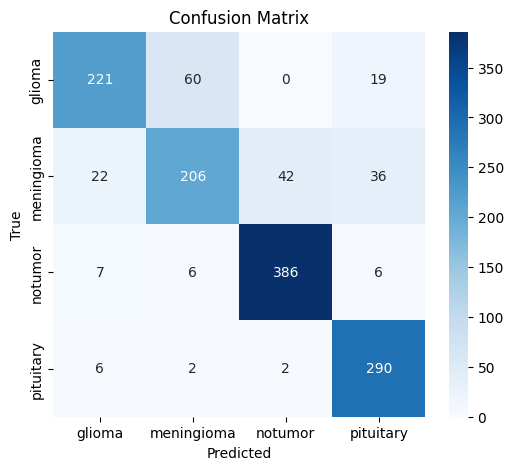

In [ ]:
# MobileNetV2
from tensorflow.keras.applications import MobileNetV2
reset_generators(tf.keras.applications.mobilenet_v2.preprocess_input)
base_mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobile_model = build_model(base_mobile)
histories['MobileNetV2'] = mobile_model.fit(train_generator, validation_data=test_generator, epochs=15, verbose=1)
print("Evaluating MobileNetV2...")
mobile_metrics = evaluate_model(mobile_model, test_generator, list(class_indices.keys()))
results.append(('MobileNetV2',) + mobile_metrics)

# Plot Accuracy & Loss Curves for All Models
🔹 Description:

* Visualize training and validation accuracy/loss side by side for each model

* Helps compare learning behavior, convergence, and overfitting trends

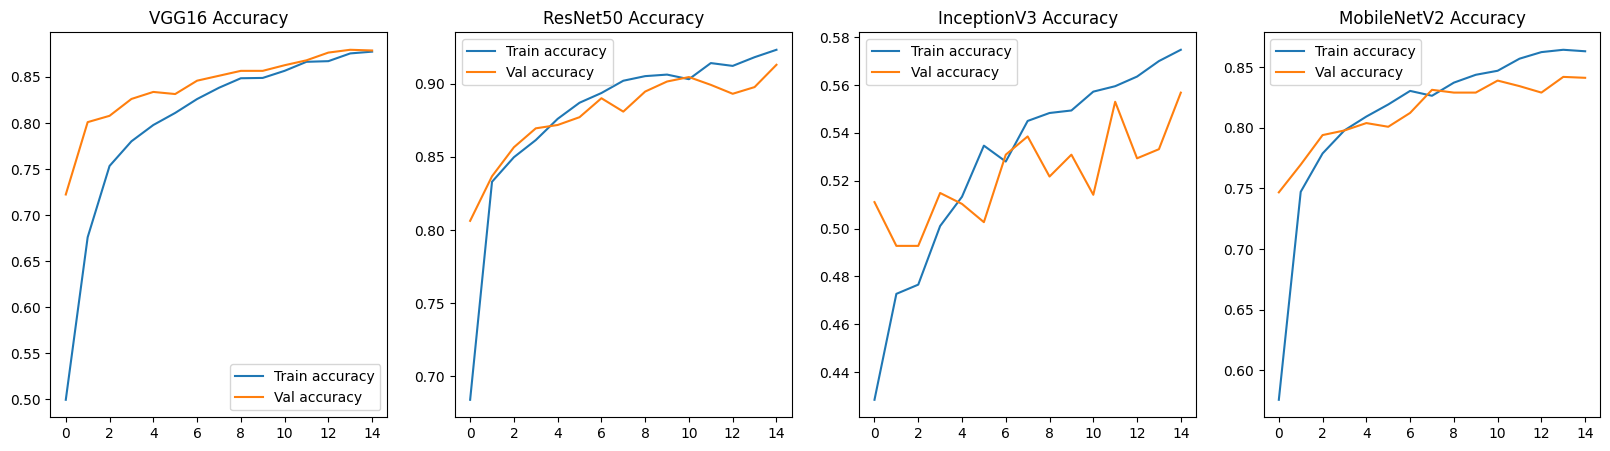

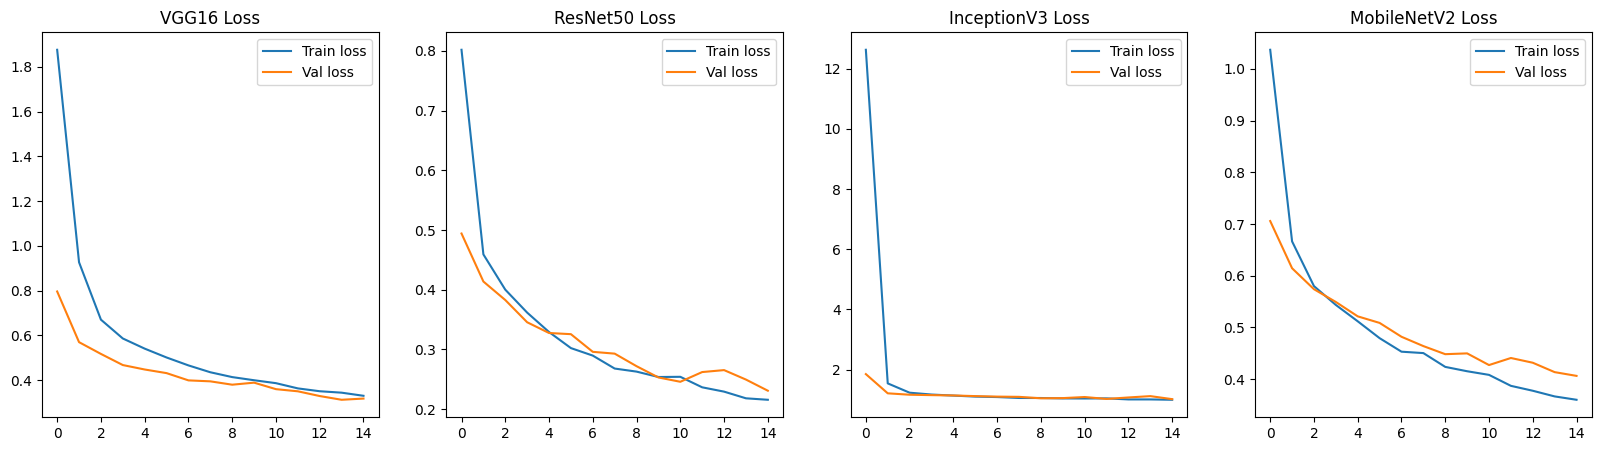

In [ ]:
# STEP 7: PLOT ACCURACY AND LOSS GRAPHS SIDE BY SIDE

plot_history(histories, metric='accuracy')
plot_history(histories, metric='loss')

# Plot Confusion Matrices for All Models

🔹 Description:

* Show confusion matrices for each model side by side

* Visualize how well each model distinguishes between tumor classes

* Identify misclassifications across categories



41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


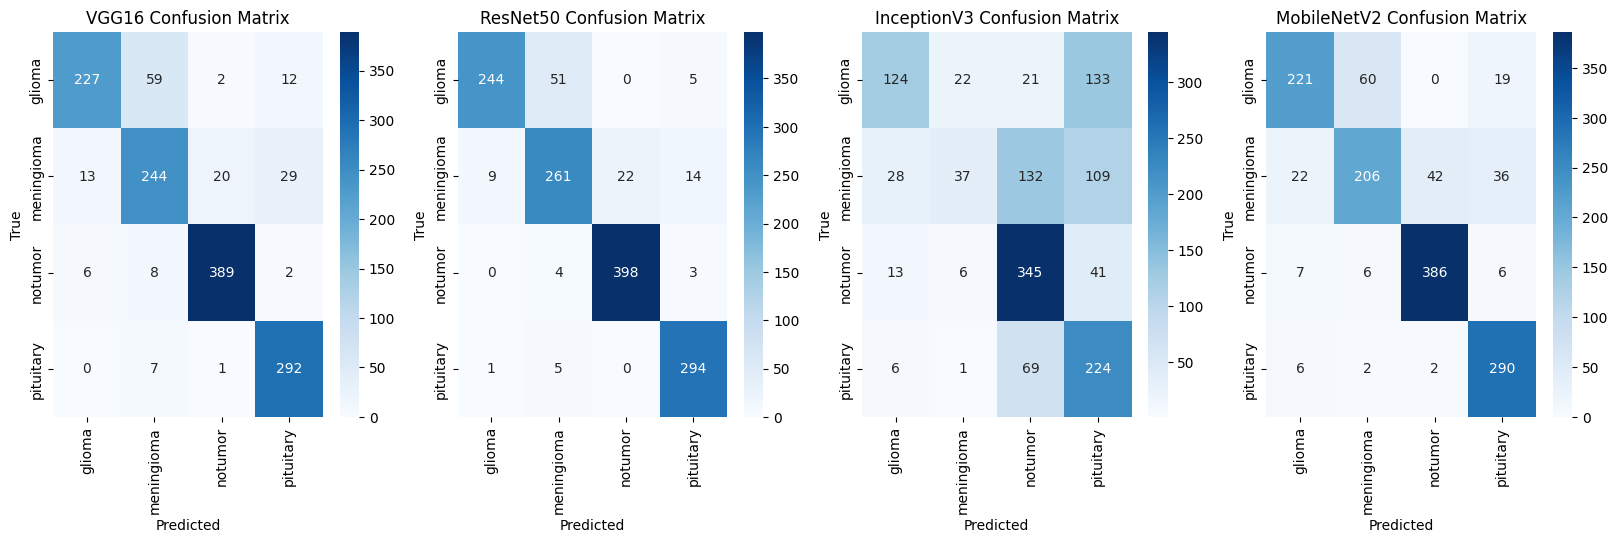

In [ ]:
# STEP 8: PLOT CONFUSION MATRICES SIDE BY SIDE

def plot_confusion_matrices(models, generators, class_names):
    plt.figure(figsize=(20, 5))
    for i, (name, model) in enumerate(models.items()):
        y_true = generators.classes
        y_pred_probs = model.predict(generators)
        y_pred = y_pred_probs.argmax(axis=1)
        cm = confusion_matrix(y_true, y_pred)
        plt.subplot(1, len(models), i+1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    plt.show()

models_dict = {
    'VGG16': vgg_model,
    'ResNet50': resnet_model,
    'InceptionV3': inception_model,
    'MobileNetV2': mobile_model
}

plot_confusion_matrices(models_dict, test_generator, list(class_indices.keys()))



# Compare Model Performance (Table + Chart)

🔹 Description:

* Create a summary table with Accuracy, F1 Score, Precision, Recall, and AUC for all models

* Sort models by F1 Score for fair comparison

* Visualize metrics with a grouped bar chart

         Model  Accuracy  F1 Score  Precision    Recall       AUC
0     ResNet50  0.913043  0.912390   0.915250  0.913043  0.987597
1        VGG16  0.878719  0.877445   0.881392  0.878719  0.978729
2  MobileNetV2  0.841342  0.837207   0.839408  0.841342  0.968131
3  InceptionV3  0.556827  0.513254   0.585860  0.556827  0.826514


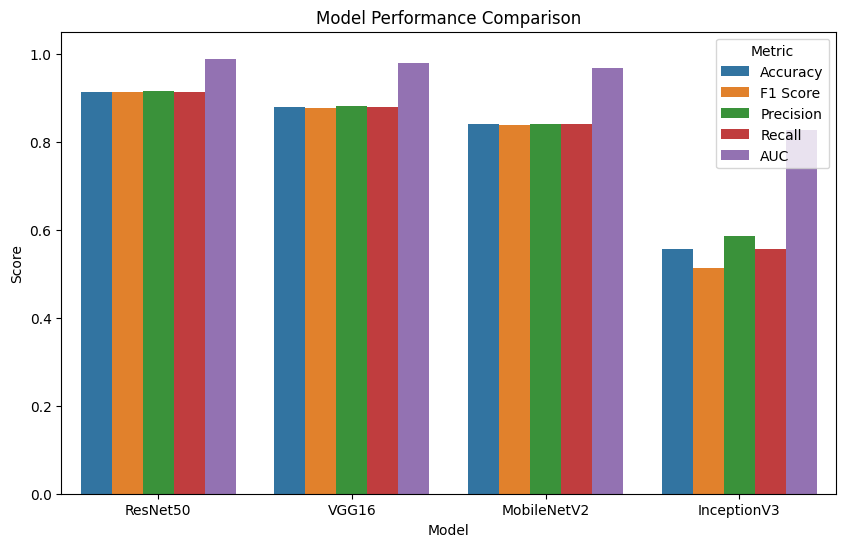

In [ ]:
# STEP 9: DISPLAY COMPARISON TABLE

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'AUC'])

# Some AUC might be None if error occurred, replace with 0 for sorting
results_df['AUC'] = results_df['AUC'].fillna(0)

results_df = results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)
print(results_df)

# Plot comparison
plt.figure(figsize=(10,6))
results_melt = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=results_melt, x='Model', y='Score', hue='Metric')
plt.title("Model Performance Comparison")
plt.ylim(0, 1.05)
plt.show()